# Geometric Multigrid

Multigrid uses a hierarchy of scales to produce an operation "$M^{-1}$" that can be applied in linear time and such that $\lVert I - M^{-1} A \rVert \le \rho < 1$ independent of the problem size.
We'll consider the one dimensional case using the stencil
$$ \frac{1}{h^2} \begin{bmatrix} -1 & 2 & -1 \end{bmatrix} $$
for the negative Laplacian. For convenience, we will scale the matrix by the constant $h^2/2$ so that the diagonal is 1.

## Spectrum of discrete operator
Let's refresh our memory about the spectrum of the discrete Laplacian.

smallest: [0.00047428 0.00189667 0.00426582 0.00757949]
largest:  [1.99242051 1.99573418 1.99810333 1.99952572]
cond 4215.915727604939


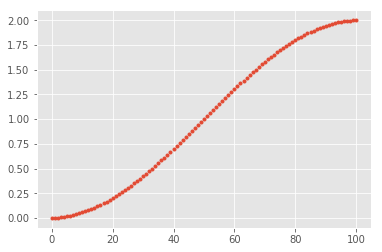

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def laplace_dirichlet(m):
    x = numpy.linspace(0, 1, m)
    A = numpy.eye(m) - .5*numpy.eye(m,k=1) - .5*numpy.eye(m,k=-1)
    return x, A

m = 101
#returns the x values and the matrix A
x, A = laplace_dirichlet(m)
#eigenvectors, eigenvalues corresponding to the eigenvectors
L, X  = numpy.linalg.eigh(A)

pyplot.plot(L, '.')

print('smallest: {}'.format(L[:4]))
print('largest:  {}'.format(L[-4:]))
print('cond', L[-1]/L[0])

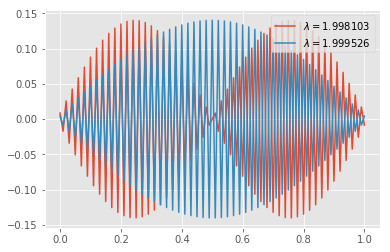

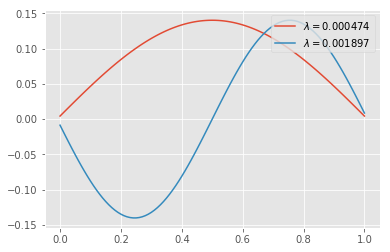

In [2]:
# Modes associated with the smallest eigenvalues
for i in (-2, -1):
    pyplot.plot(x, X[:,i], label='$\lambda = %f$' % L[i])
pyplot.legend(loc='upper right')
pyplot.show();
for i in (0,1):
    pyplot.plot(x, X[:,i], label='$\lambda = %f$' % L[i])
pyplot.legend(loc='upper right')
pyplot.show();

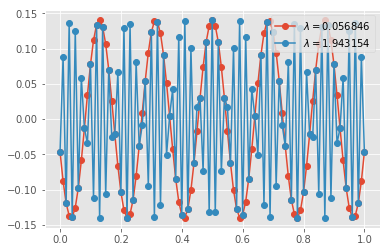

In [3]:
# Examples from both ends of the spectrum
for i in (10,90):
    pyplot.plot(x, X[:,i], '-o', label='$\lambda = %f$' % L[i])
pyplot.legend(loc='upper right');

**What is this graph showing again?**

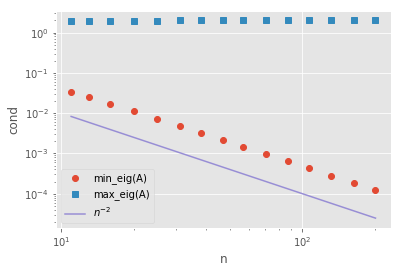

In [4]:
# The condition number grows with problem size
ns = numpy.geomspace(11, 201, 15, dtype=int)
eigs = numpy.array([numpy.linalg.eigvalsh(laplace_dirichlet(n)[1])[[0, -1]] for n in ns])
pyplot.loglog(ns, eigs[:,0], 'o', label='min_eig(A)')
pyplot.loglog(ns, eigs[:,-1], 's', label='max_eig(A)')
pyplot.loglog(ns, ns**(-2.), '-', label='$n^{{-2}}$')
pyplot.xlabel('n')
pyplot.ylabel('cond')
pyplot.legend();

### Fourier Analysis perspective

Consider the basis $\phi(x, \theta) = e^{i \theta x}$.  If we choose the grid $x \in h \mathbb Z$ with grid size $h$ then we can resolve frequencies $\lvert \theta \rvert \le \pi/h$.

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


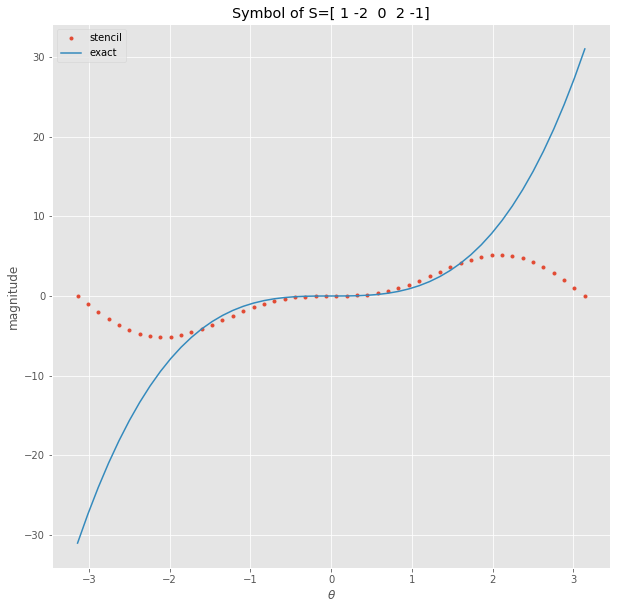

In [56]:
def symbol(S, theta):
    """Compute the symbol of the stencil S(theta)"""
    if len(S) % 2 != 1:
        raise RuntimeError('Stencil length must be odd')
    w = len(S) // 2 # integer division rounds down
    phi = numpy.exp(1j * numpy.outer(range(-w, w+1), theta))
    return numpy.real_if_close(S @ phi)

def plot_symbol(S, ref_deriv=None, label='stencil'):
    theta = numpy.linspace(-numpy.pi, numpy.pi)
    sym = symbol(S, theta)
    pyplot.figure(figsize=(10,10))
    pyplot.plot(theta, -1j*sym, '.', label=label)
    if ref_deriv is not None:
        pyplot.plot(theta, theta**ref_deriv, '-', label='exact')
    pyplot.legend()
    pyplot.title('Symbol of S={}'.format(S))
    pyplot.xlabel(r'$\theta$')
    pyplot.ylabel('magnitude')

laplace_stencil = numpy.array([1, -2, 0, 2, -1])
plot_symbol(laplace_stencil, ref_deriv=3);

The lowest frequency function resolvable with Dirichlet boundary conditions on a grid of size $(n-1) h$ has wavelength $\lambda = 2 (n-1) h$, thus frequency $\theta_{\min} = 2\pi/\lambda$.

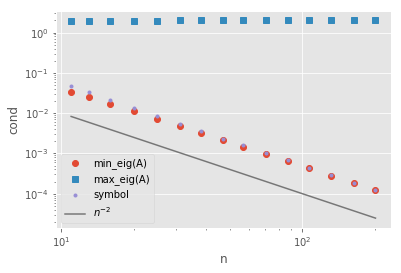

In [6]:
theta_min = numpy.pi / (ns - 1)
symbol_min = symbol(laplace_stencil, theta_min)
pyplot.loglog(ns, eigs[:,0], 'o', label='min_eig(A)')
pyplot.loglog(ns, eigs[:,-1], 's', label='max_eig(A)')
pyplot.loglog(ns, symbol_min * eigs[:,-1]/4, '.', label='symbol')
pyplot.loglog(ns, ns**(-2.), '-', label='$n^{{-2}}$')
pyplot.xlabel('n')
pyplot.ylabel('cond')
pyplot.legend();

### Damping properties of Richardson/Jacobi relaxation

Recall that we would like for $I - w A$ to have a small norm, such that powers (repeat iterations) will cause the error to decay rapidly.

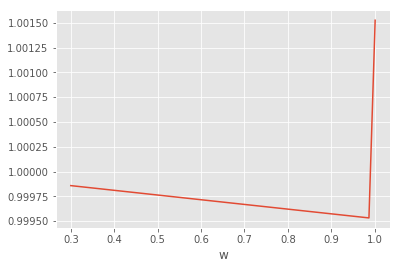

In [7]:
I = numpy.eye(*A.shape)
ws = numpy.linspace(.3, 1.001, 50)
#A is from the laplacian problem earlier in the notebook
radius = [numpy.linalg.norm(I - w*A, ord=2) for w in ws]
pyplot.plot(ws, radius)
pyplot.xlabel('w');

* The spectrum of $A$ runs from $\theta_{\min}^2$ up to 2.  If $w > 1$, then $\lVert I - w A \rVert > 1$ because the operation amplifies the high frequencies (associated with the eigenvalue of 2).
* The value of $w$ that minimizes the norm is slightly less than 1, but the convergence rate is very slow (only barely less than 1).

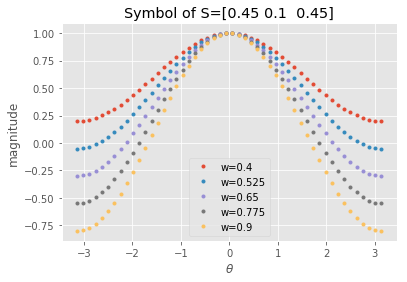

In [8]:
for w in numpy.linspace(.4, .9, 5):
    plot_symbol(numpy.array([0, 1, 0] - w*.5*laplace_stencil), label='w={}'.format(w))

At frequencies $ > \frac{\pi}{2} $ it is easy to differentiate, but at lower frequencies it is much more difficult.

Evidently it is very difficult to damp low frequencies.  This makes sense because $A$ and $I - w A$ move information only one grid point per iteration.

## Coarse grids: Make low frequencies high again

As in domain decomposition, we will express our "coarse" subspace, consisting of a grid $x \in 2h\mathbb Z$, in terms of its interpolation to the fine space.  Here, we'll use linear interpolation.

(101, 51)

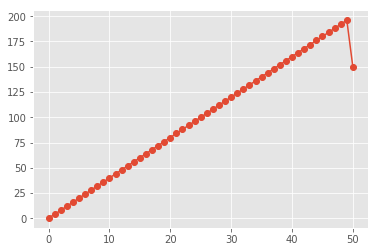

In [40]:
#this is just creating the restriction grid. 0 -> 0, 1 -> 2, 2 -> 4, etc...


def interpolate(m, stride=2):
    if stride == 2:
        P = numpy.eye(m) + .5*numpy.eye(m,k=1) + .5*numpy.eye(m,k=-1)
    elif stride == 3:
        P = numpy.eye(m) + 2./3*(numpy.eye(m,k=1)+numpy.eye(m,k=-1)) + \
            1./3*(numpy.eye(m,k=2)+numpy.eye(m,k=-2))
    return P[:, ::stride]

P = interpolate(len(A), stride=2)
u = numpy.linspace(0,50,51)
uu = numpy.linspace(0,100,101)
pyplot.plot(u,P.T @ uu, '-o')
P.shape

We can "restrict" a fine-grid vector to the coarse space by
$$ u^{2h} = \frac 1 2 P^T u^h .$$
P is the linear interpolation to the fine space.
This is an accurate approximation for low frequency functions, but inaccurate for high frequencies.

In [ ]:
pyplot.plot(1./2 *P.dot(P.T @ X[:,67]), label='coarse')
pyplot.plot(X[:,67], label='fine')
pyplot.legend(loc='upper right');

The "Galerkin" approximation of the operator $A$ in the coarse space is
$$ A^{2h} = P^T A P . $$

(51, 51)


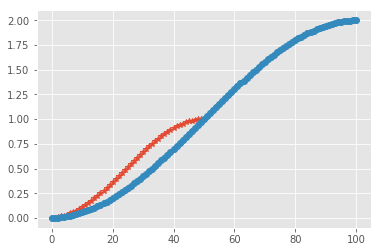

In [43]:
#Again, P is the interpolation function created earlier

Ac = P.T @ A @ P
print(Ac.shape)

Lc, Xc = numpy.linalg.eigh(Ac)
pyplot.figure()
pyplot.plot(Lc, '*');
pyplot.plot(L, 'o');

array([[ 0.75, -0.25,  0.  ,  0.  ,  0.  ],
       [-0.25,  0.5 , -0.25,  0.  ,  0.  ],
       [ 0.  , -0.25,  0.5 , -0.25,  0.  ],
       [ 0.  ,  0.  , -0.25,  0.5 , -0.25],
       [ 0.  ,  0.  ,  0.  , -0.25,  0.5 ]])

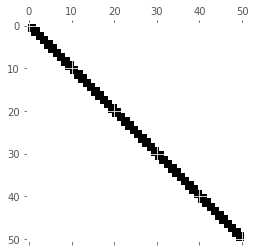

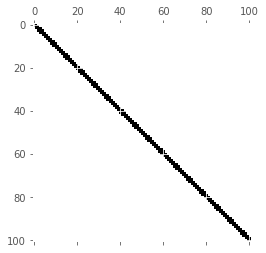

In [46]:
# The coarse grid operator has comparable sparsity (tridiagonal here)
# to the fine grid operator.
pyplot.figure()
pyplot.spy(Ac);
pyplot.figure()
pyplot.spy(A);
Ac[:5,:5]


Evidently the coarse operator looks like a discretization of the Laplacian on a coarser grid (modulo boundary conditions).  Let's consider the $A$-orthogonal projector onto the range of $P$,
$$ S_c = \underbrace{P A_c^{-1} P^T}_{M_c^{-1}} A . $$

7.203322700177904e-15


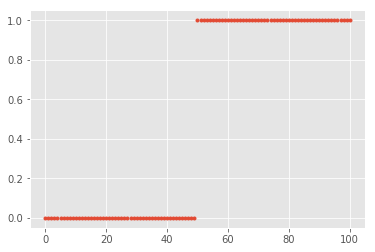

In [47]:
# Consider the A-orthogonal projector into the range of P
Sc = P @ numpy.linalg.inv(Ac) @ P.T @ A
Ls, Xs = numpy.linalg.eig(Sc)
print(max(abs(Ls.imag)))
Ls = Ls.real
idx = Ls.argsort()
Ls = Ls[idx]; Xs = Xs[:,idx]

pyplot.plot(Ls, '.');

* This spectrum is typical for a projector. For all vectors $x$ in the range of $P$, we know that $S_c x = x$.  Why?  Check
$$ S_c \underbrace{P y}_{x} .$$
* Meanwhile, for all vectors $x$ that are $A$-orthogonal to the range of $P$, we know that $S_c x = 0$.  Why?

## Two-grid method

The two-grid method using these coarse basis functions converges almost an order of magnitude per iteration.

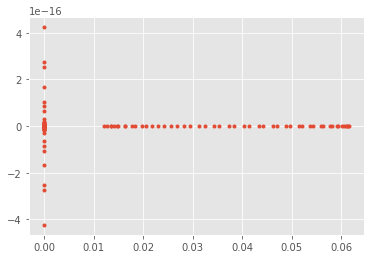

In [52]:
# Iteration matrix for a V(1,1) cycle
Lt, Xt = numpy.linalg.eig((I - .67*A) @ (I - Sc) @ (I - .67*A))
Lt, Xt = numpy.linalg.eig((I - .67*A) @ (I - .67*A) @ (I - Sc) @ (I - .67*A) @ (I - .67*A))
pyplot.plot(Lt.real, Lt.imag, '.');

### Choices for linear multigrid
* Smoother
* Interpolation $P$ (coarse basis)
* Restriction ($P^T$, or different for non-symmetric problems)
* Coarse operator (Galerkin $P^T A P$, rediscretization)

## Multigrid as factorization

We can interpret factorization as a particular multigrid or domain decomposition method.

We can partition an SPD matrix as
$$J = \begin{bmatrix} F & B^T \\ B & D \end{bmatrix}$$
and define the preconditioner by the factorization
$$      M = \begin{bmatrix} I & \\ B F^{-1} & I \end{bmatrix}
      \begin{bmatrix} F &  \\ & S \end{bmatrix}
      \begin{bmatrix} I & F^{-1}B^T \\  & I \end{bmatrix}
$$
where $S = D - B F^{-1} B^T$.  $M$ has an inverse
$$      M^{-1} =
      \begin{bmatrix} I & -F^{-1}B^T \\  & I \end{bmatrix}
      \begin{bmatrix} F^{-1} &  \\ & S^{-1} \end{bmatrix}
      \begin{bmatrix} I & \\ -B F^{-1} & I \end{bmatrix} .
$$
Define the interpolation
$$ P_f = \begin{bmatrix} I \\ 0 \end{bmatrix}, \quad P_c = \begin{bmatrix} -F^{-1} B^T \\ I \end{bmatrix} $$ and rewrite as
$$ M^{-1} = [P_f\  P_c] \begin{bmatrix} F^{-1} P_f^T \\ S^{-1} P_c^T \end{bmatrix} = P_f F^{-1} P_f^T + P_c S^{-1} P_c^T.$$
The iteration matrix is thus
$$ I - M^{-1} J = I - P_f F^{-1} P_f^T J - P_c S^{-1} P_c^T J .$$

### Permuted matrix $J$
In this ordering for our 1D Laplacian, the $F$ block is diagonal.

In [ ]:
m = len(A)
idx = numpy.concatenate((numpy.arange(0,m,2), numpy.arange(1,m,2)))
J = A[:,idx][idx,:]
pyplot.spy(J);

In [ ]:
mf = m // 2 + 1
Pf = numpy.concatenate((numpy.eye(mf), numpy.zeros((m-mf, mf))))
Jf = Pf.T @ J @ Pf
Pc = numpy.concatenate((-numpy.linalg.inv(Jf).dot(J[:mf,mf:]), numpy.eye(m-mf)))
Jc = Pc.T.dot(J.dot(Pc))

Mf = Pf.dot(numpy.linalg.inv(Jf)).dot(Pf.T)
Mc = Pc.dot(numpy.linalg.inv(Jc)).dot(Pc.T)
T = I - (Mf + Mc).dot(J)
#T = (I - Mf.dot(J)).dot(I - Mc.dot(J))
#T = (I - .67*J).dot(I - Mc.dot(J))
#T = T.dot(T)
#T = (I - .67*J).dot(I - .67*J).dot(I - Mc.dot(J)).dot(I - .67*J)
#T = I - .67*J - Mc.dot(J)
Lt, Xt = numpy.linalg.eig(T)
pyplot.plot(Lt.real, Lt.imag, '.');

In [ ]:
# Invert the permutation
idxinv = numpy.zeros(m, dtype=int)
idxinv[idx] = numpy.arange(m)

# Plot the coarse basis function in the original ordering
pyplot.plot(Pc[:,5][idxinv], '-o');

In [ ]:
M = numpy.array([[1,2],[2,1]])
numpy.linalg.eigh(M)

# Algebraic Multigrid

Factorization as a multigrid (or domain decomposition) method incurs significant cost in multiple dimensions due to lack of sparsity.  It is not feasible to choose enough coarse basis functions so that coarse basis functions that use minimum energy extensions $-F^{-1} B^T$ (see $P_c$ and the notation above) have sufficiently local support.

Algebraic multigrid methods operate by specifying a coarsening algorithm and degree of sparsity, then attempting to choose good basis functions within those constraints.  Classical AMG chooses coarse points much like the factorization methods above, but restricts the support of the basis functions and uses heuristics to weight the contributions in order to approximate selected functions (like the constant).  Smoothed aggregation chooses aggregates and *tentative* basis functions $T$ on the aggregates (to reproduce the constants or other functions exactly), then uses Jacobi relaxation to compute an interpolation $P = (I - \omega D^{-1} J)T$ which is smoother than $T$, but with correspondingly larger support.

Let's examine this construction of basis functions for the 1D Laplacian.

In [ ]:
cfactor = 3
agg = numpy.arange(m) // cfactor
mc = max(agg)+1
T = numpy.zeros((m,mc))
T[numpy.arange(m), agg] = 1

pyplot.plot(T[:6*cfactor,2:5], '-o');

 ### Plain aggregation
 
 We can use the tentative prolongation $T$ in a multigrid algorithm.  This is called plain aggregation and converges relatively slowly (note the relatively large maximum eigenvalue of the error iteration matrix).

In [ ]:
Ac = T.T @ A @ T
Sc = T @ numpy.linalg.inv(Ac) @ T.T @ A
Lt, Xt = numpy.linalg.eig((I - .67*A) @ (I - Sc) @ (I - .67*A))
pyplot.plot(Lt.real, Lt.imag, '.');

### Smoothed aggregation

By performing one iteration of Jacobi relaxation
$$ P = (I - w A) T $$
we create coarses basis functions that more accurately approximate the smooth functions.

In [ ]:
P = (I - .67*A) @ T

pyplot.plot(P[:6*cfactor,2:5], '-o');

We can form the Galerkin coarse operator using these smoothed coarse basis functions $A_c = P^T A P$ and observe better convergence than with plain aggregation.  We alse experiment with multiple smoothing iterations and adjusting their weights.

In [ ]:
Ac = P.T @ A @ P
Sc = P @ numpy.linalg.inv(Ac) @ P.T @ A
# Uniform convergence rate, though not as good as with
# a slower coarsening rate.
Lt, Xt = numpy.linalg.eig((I - .67*A) @ (I - Sc) @ (I - .67*A))
## Stronger smoothing helps
# Lt, Xt = numpy.linalg.eig((I - .67*A) @ (I - .67*A) @ (I - Sc) @ (I - .67*A) @ (I - .67*A))
## And this can be tuned
# w1, w2 = .6, 1
# Lt, Xt = numpy.linalg.eig((I - w2*A) @ (I - w1*A) @ (I - Sc) @ (I - w1*A) @ (I - w2*A))

pyplot.plot(Lt.real, Lt.imag, '.');

* What if we use a more rapid coarsening factor?
* How can we replace Jacobi relaxation with Gauss-Seidel?